# Diffusion tensor imaging processing notes

This must be run in the `dwit_nipype` environment
Our pipeline is the following:

1. we look at the bval file for each image to confirm the bval is zero on the first volume, therefore this first volume can be used as a b0 image

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from dipy.io.gradients import read_bvals_bvecs
import nibabel as nib
from nipype import Workflow, Node, MapNode, Function
from nipype.interfaces.fsl import BET, IsotropicSmooth, ApplyMask


In [2]:
image_directory= '/mnt/data/raw_data/images/niftis/just_dti'
folders_list = os.listdir(image_directory)

1: we here will look into each b_val file (by printting it out) for our DTI to confirm that the first volume contains the b_0 image
2. we will use nibabel to extract our b_0 images and save them with a b0 name in the same folder
2. we will extract a brain mask from the b0 images but running bet tool (this is done with fsl in command line)

In [3]:
for folder in folders_list:
    folder_name = folder
    print(folder_name)
    file_list = os.listdir(os.path.join(image_directory,folder))
    for file in file_list:
        if file.endswith('bval'):
            bval = file
            print(bval)
        if file.endswith('bvec'):
            bvec = file
            gt_bvals, gt_bvec = read_bvals_bvecs(os.path.join(image_directory,folder,bval), os.path.join(image_directory,folder,bvec))
            print(gt_bvals)


BRICK-001
004_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_20220620000000.bval
[  0.   0.   0. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.]
BRICK-002
004_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_20220620000000.bval
[  0.   0.   0. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.]
BRICK-003
004_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_20220620000000.bval
[  0.   0.   0. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.]
BRICK-004
004_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_N

Great ! As expected we have b0 images , let's write a function to extract our b0 images with nibabel

First let' look at some of them just to check we are on the riht planet

In [4]:
def view_b0(input_dti_path):#, ouput_b0_path):
    dti = nib.load(input_dti_path)
    dti_image = dti.get_fdata()
    b0_data = dti_image[..., 0]
    print(b0_data.shape)
    plt.imshow(b0_data[:,:,30], cmap='Greys')
    

(120, 120, 65)


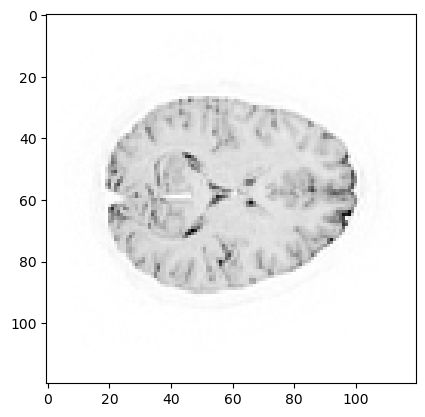

In [5]:
view_b0(
    os.path.join(
        image_directory,
        'BRICK-001', 
        '004_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_20220620000000.nii.gz'
    ))

## Note: many images were also checked by hand in fsleyes

Now let's actually extract and show our B0 images to a file: this is an example on BRICK-001

In [6]:
def extract_b0(input_dti_path,output_b0_path):
    dti = nib.load(input_dti_path)
    dti_image = dti.get_fdata()
    b0_data = dti_image[..., 0]
    plt.imshow(b0_data[:,:,30], cmap='Greys')
    b0_image = nib.Nifti1Image(b0_data, affine=dti.affine, header= dti.header)
    nib.save(b0_image, output_b0_path)
    print("b0 saved at", output_b0_path)

b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-001/b0.nii.gz


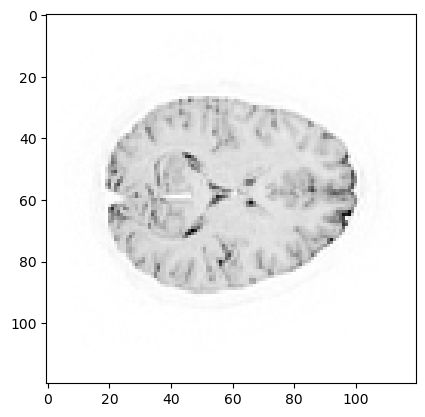

In [7]:
extract_b0(
    os.path.join(
        image_directory,
        'BRICK-001', 
        '004_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_20220620000000.nii.gz'
    ),
os.path.join(
        image_directory,
        'BRICK-001', 
        'b0.nii.gz'
    ),
)

In [8]:
# view_b0(
#     os.path.join(
#         image_directory,
#         'BRICK-018', 
#         '004_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_New_DTI-Ax-35DIR-2.5mm_TR11.5_TE93_b900_PA_20220919000000.nii.gz'
#     )
# )

In [9]:
# Now we can loop and do this for every image anfter BRICK-001:

# We will also exclude brick 18 , brick -27, brick 58 because these files appear corrupt

BRICK-002
/mnt/data/raw_data/images/niftis/just_dti/BRICK-002/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-002/b0.nii.gz
BRICK-003
/mnt/data/raw_data/images/niftis/just_dti/BRICK-003/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-003/b0.nii.gz
BRICK-004
/mnt/data/raw_data/images/niftis/just_dti/BRICK-004/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-004/b0.nii.gz
BRICK-005
/mnt/data/raw_data/images/niftis/just_dti/BRICK-005/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-005/b0.nii.gz
BRICK-006
/mnt/data/raw_data/images/niftis/just_dti/BRICK-006/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-006/b0.nii.gz
BRICK-007
/mnt/data/raw_data/images/niftis/just_dti/BRICK-007/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-007/b0.nii.gz
BRICK-008
/mnt/data/raw_data/images/niftis/just_dti/BRICK-008/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dt

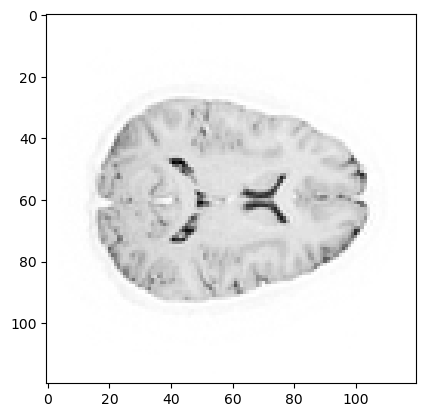

In [10]:
for folder in folders_list[1:16]:
    folder_name = folder
    print(folder_name)
    file_list = os.listdir(os.path.join(image_directory,folder))
    for file in file_list:
        if file.endswith('nii.gz') and not file.endswith('b0.nii.gz'):
            nifti = file
            nifti_path = os.path.join(image_directory,folder,nifti)
            b0_path =  os.path.join(
                    image_directory,
                    folder_name, 
                    'b0.nii.gz'
                )
            print(b0_path)
            extract_b0(nifti_path, b0_path)

BRICK-019
/mnt/data/raw_data/images/niftis/just_dti/BRICK-019/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-019/b0.nii.gz
BRICK-020
/mnt/data/raw_data/images/niftis/just_dti/BRICK-020/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-020/b0.nii.gz
BRICK-021
/mnt/data/raw_data/images/niftis/just_dti/BRICK-021/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-021/b0.nii.gz
BRICK-023
/mnt/data/raw_data/images/niftis/just_dti/BRICK-023/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-023/b0.nii.gz
BRICK-026
/mnt/data/raw_data/images/niftis/just_dti/BRICK-026/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-026/b0.nii.gz


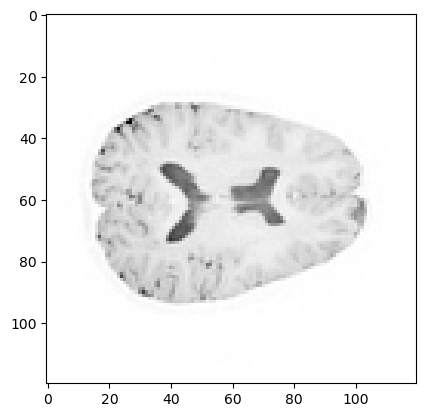

In [11]:
for folder in folders_list[17:22]:
    folder_name = folder
    print(folder_name)
    file_list = os.listdir(os.path.join(image_directory,folder))
    for file in file_list:
        if file.endswith('nii.gz') and not file.endswith('b0.nii.gz'):
            nifti = file
            nifti_path = os.path.join(image_directory,folder,nifti)
            b0_path =  os.path.join(
                    image_directory,
                    folder_name, 
                    'b0.nii.gz'
                )
            print(b0_path)
            extract_b0(nifti_path, b0_path)

BRICK-028
/mnt/data/raw_data/images/niftis/just_dti/BRICK-028/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-028/b0.nii.gz
BRICK-029
/mnt/data/raw_data/images/niftis/just_dti/BRICK-029/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-029/b0.nii.gz
BRICK-030
/mnt/data/raw_data/images/niftis/just_dti/BRICK-030/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-030/b0.nii.gz
BRICK-032
/mnt/data/raw_data/images/niftis/just_dti/BRICK-032/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-032/b0.nii.gz
BRICK-033
/mnt/data/raw_data/images/niftis/just_dti/BRICK-033/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-033/b0.nii.gz
BRICK-035
/mnt/data/raw_data/images/niftis/just_dti/BRICK-035/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-035/b0.nii.gz
BRICK-037
/mnt/data/raw_data/images/niftis/just_dti/BRICK-037/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dt

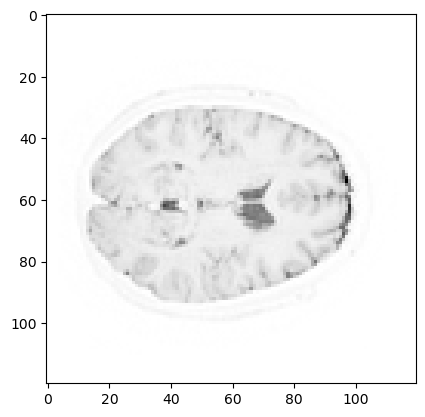

In [12]:
for folder in folders_list[23:49]:
    folder_name = folder
    print(folder_name)
    file_list = os.listdir(os.path.join(image_directory,folder))
    for file in file_list:
        if file.endswith('nii.gz') and not file.endswith('b0.nii.gz'):
            nifti = file
            nifti_path = os.path.join(image_directory,folder,nifti)
            b0_path =  os.path.join(
                    image_directory,
                    folder_name, 
                    'b0.nii.gz'
                )
            print(b0_path)
            extract_b0(nifti_path, b0_path)

BRICK-059
/mnt/data/raw_data/images/niftis/just_dti/BRICK-059/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-059/b0.nii.gz
BRICK-060_2023
/mnt/data/raw_data/images/niftis/just_dti/BRICK-060_2023/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-060_2023/b0.nii.gz
BRICK-060_2024
/mnt/data/raw_data/images/niftis/just_dti/BRICK-060_2024/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-060_2024/b0.nii.gz
BRICK-061
/mnt/data/raw_data/images/niftis/just_dti/BRICK-061/b0.nii.gz
b0 saved at /mnt/data/raw_data/images/niftis/just_dti/BRICK-061/b0.nii.gz


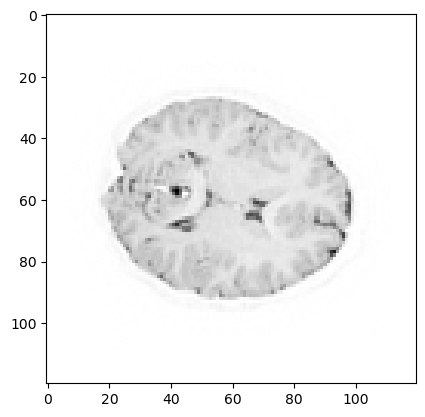

In [13]:
for folder in folders_list[50:]:
    folder_name = folder
    print(folder_name)
    file_list = os.listdir(os.path.join(image_directory,folder))
    for file in file_list:
        if file.endswith('nii.gz') and not file.endswith('b0.nii.gz'):
            nifti = file
            nifti_path = os.path.join(image_directory,folder,nifti)
            b0_path =  os.path.join(
                    image_directory,
                    folder_name, 
                    'b0.nii.gz'
                )
            print(b0_path)
            extract_b0(nifti_path, b0_path)

# Now we created b0 images in each folder. WE now can the bet on all our b0 images